In [1]:
import sys
import json
import itertools
import numpy as np
from math import log, floor
from random import random, randint
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from joblib import Parallel, delayed
from collections import Counter, defaultdict

In [2]:
ZERO = 0.001
ONE  = 0.999
conditional_set_four_neighbours_cached = {}

In [3]:
def cp(x, p):
    return p if x == 1 else (1-p)

def make_unconditional_set(p0):
    return lambda: random() < p0

def make_conditional_set_one_neighbour(p):
    return lambda n: (n) if (random() < p) else (1 - n)

def calculate_conditional_probs_for_1(p0, p):
    q = 1 - p
    joint_probs = {
        '000': p0 * p * p,
        '111': p0 * p * p,
        '010': p0 * q * q,
        '101': p0 * q * q,
        '110': p0 * p * q,
        '011': p0 * p * q,
        '001': p0 * p * q,
        '100': p0 * p * q,
    }
    return {
        '00': joint_probs['010']/(joint_probs['010']+joint_probs['000']),
        '01': joint_probs['011']/(joint_probs['011']+joint_probs['001']),
        '10': joint_probs['110']/(joint_probs['110']+joint_probs['100']),
        '11': joint_probs['111']/(joint_probs['111']+joint_probs['101']),
    }

def make_conditional_set_two_neighbours(p0, p):
    conditional_probs_for_1 = calculate_conditional_probs_for_1(p0, p)
    return lambda n1, n2: random() < conditional_probs_for_1[str(int(n1))+str(int(n2))]
    
def create_grid(rows, cols, p0, p):
    unconditional_set = make_unconditional_set(p0)
    conditional_set_one_neighbour = make_conditional_set_one_neighbour(p)
    conditional_set_two_neighbours = make_conditional_set_two_neighbours(p0, p)
    grid = np.zeros([rows, cols], np.uint8)    
    # first element
    grid[0, 0] = unconditional_set()
    # first row
    for j in range(1, cols):
        grid[0, j] = conditional_set_one_neighbour(grid[0, j-1])
    # remaining rows
    for i in range(1, rows):
        grid[i, 0] = conditional_set_one_neighbour(grid[i-1, 0])
        for j in range(1, cols):
            grid[i, j] = conditional_set_two_neighbours(grid[i-1, j], grid[i, j-1])
    # make it symmetric
    if random() < 0.5:
        grid = np.fliplr(grid)
    if random() < 0.5:
        grid = np.flipud(grid)
    if rows == cols and random() < 0.5:
        grid = np.rot90(grid)
    return grid

def show(grid):
    plt.imshow(grid, cmap='hot', interpolation='nearest')
    plt.axis('off')
    plt.show()

def make_star_conditional(rows, cols, p0, p, num_simulations=1000):
    joint_frequencies, total = defaultdict(int), 0
    for simulation in range(num_simulations):
        pct = int((simulation / num_simulations) * 10000) / 100
        print(f'Computing conditionals for the {rows}x{cols} spin glass, progress {pct}% ', end='\r')
        sys.stdout.flush()
        grid = create_grid(rows, cols, p0, p)
        for i in range(1, rows-1):
            for j in range(1, cols-1):
                pattern = '%d%d%d%d%d' % (grid[i, j], grid[i, j-1], grid[i, j+1], grid[i-1, j], grid[i+1, j])
                joint_frequencies[pattern] += 1
                total += 1
    joint_probabilities = {} # joint_probabilities
    for pattern, freq in joint_frequencies.items():
        joint_probabilities[pattern] = freq/total
    return lambda up, down, left, right: 1 if random() < (joint_probabilities['1%d%d%d%d' % (up, down, left, right)] / (joint_probabilities['1%d%d%d%d' % (up, down, left, right)] + joint_probabilities['0%d%d%d%d' % (up, down, left, right)])) else 0

def save_animation(filename, rows, cols, p0, starting_p, p, seconds=100, frames_per_second=5, steps_per_frame=6*1000):
    cache_key = str((rows, cols, p0, p))
    if cache_key not in conditional_set_four_neighbours_cached:
        conditional_set_four_neighbours_cached[cache_key] = make_star_conditional(rows, cols, p0, p)
    conditional_set_four_neighbours = conditional_set_four_neighbours_cached[cache_key]
    num_steps = seconds * frames_per_second * steps_per_frame
    grid, frames = create_grid(rows, cols, p0, starting_p), []
    for step in range(num_steps):
        if step % steps_per_frame == 0:
            frames.append(grid.copy())
        i, j = randint(1, rows-2), randint(1, cols-2)
        grid[i, j] = conditional_set_four_neighbours(grid[i, j-1], grid[i, j+1], grid[i-1, j], grid[i+1, j])
    fig = plt.figure()
    fig.suptitle(f'starting_p={starting_p:.3f}, p={p:0.3f}')
    im = plt.imshow(frames[0], cmap='Greys', vmin=0, vmax=1)
    plt.axis('off')
    def animate_func(i):
        im.set_array(frames[i])
        return [im]
    anim = animation.FuncAnimation(fig, animate_func,
        frames=seconds*frames_per_second,
        interval=1000/frames_per_second)
    anim.save(filename, fps=frames_per_second)

def entropy(frequencies, base=2):
    return -1 * sum([f/sum(frequencies) * log(f/sum(frequencies), base) for f in frequencies])

def spin_distance(grid1, grid2):
    return sum(map(lambda x: x != 0, (grid1-grid2).flatten().tolist()))/grid1.size

def fraction(grid):
    r = np.sum(grid)/grid.size
    r = max(r, 1-r)
    return r

def get_trajectories(rows, cols, p0, starting_p, p, num_trajectories=3, seconds=100, frames_per_second = 5, steps_per_frame=6*1000):
    cache_key = str((rows, cols, p0, p))
    if cache_key not in conditional_set_four_neighbours_cached:
        conditional_set_four_neighbours_cached[cache_key] = make_star_conditional(rows, cols, p0, p)
    conditional_set_four_neighbours = conditional_set_four_neighbours_cached[cache_key]
    num_steps = seconds * frames_per_second * steps_per_frame
    trajectories = []
    starting_grid = create_grid(rows, cols, p0, starting_p)
    for t in range(num_trajectories):
        fs = []
        grid = starting_grid.copy()
        fs.append(fraction(grid))
        for step in range(num_steps):
            i, j = randint(1, rows-2), randint(1, cols-2)
            grid[i, j] = conditional_set_four_neighbours(grid[i, j-1], grid[i, j+1], grid[i-1, j], grid[i+1, j])
            if step % steps_per_frame == 0:
                fs.append(fraction(grid))
                pct = int((step / num_steps) * 10000) / 100
                print(f'Doing trajectory {t+1}/{num_trajectories} on the {rows}x{cols} spin glass, progress {pct}% ', end='\r')
                sys.stdout.flush()
        trajectories.append(fs)
    return trajectories

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


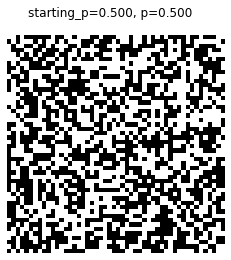

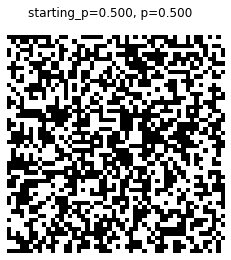

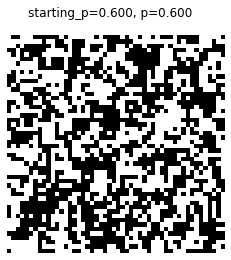

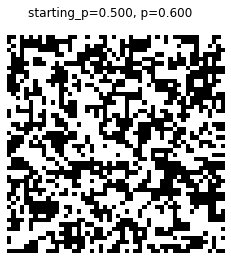

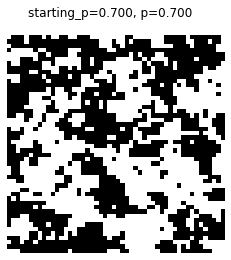

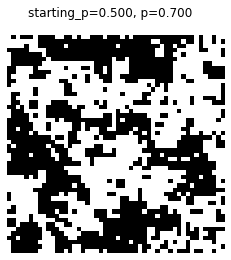

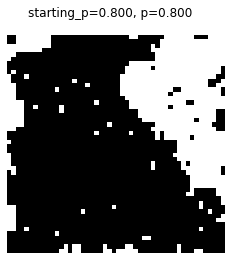

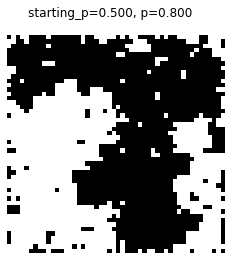

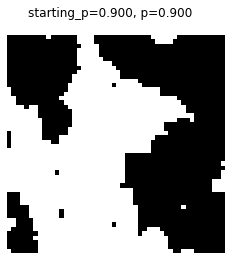

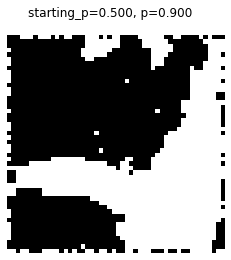

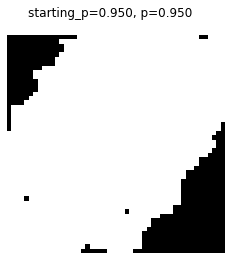

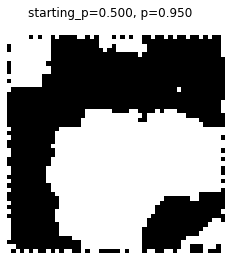

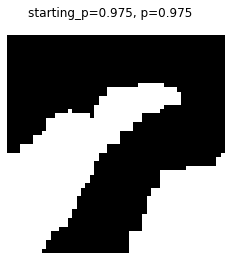

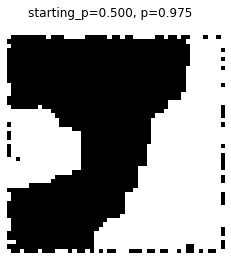

In [4]:
rows, cols, p0 = 50, 50, 0.5
for p in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975]:
    save_animation(
        filename=f'd:/temp/spin_glass_{p:.3f}.gif',
        rows=rows, cols=cols, p0=p0, starting_p=p, p=p, seconds=8,
    )
    save_animation(
        filename=f'd:/temp/spin_glass_from_noise_{p:.3f}.gif',
        rows=rows, cols=cols, p0=p0, starting_p=0.5, p=p, seconds=8,
    )

In [5]:
rows, cols, p0, ps = 50, 50, 0.5, [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975]
mts = []
for p in ps:
    for starting_p in ps:
        trajectories = get_trajectories(
            rows=rows, cols=cols, p0=p0, starting_p=starting_p, p=p, num_trajectories=1)
        mts.append((p0, starting_p, p, trajectories[0]))

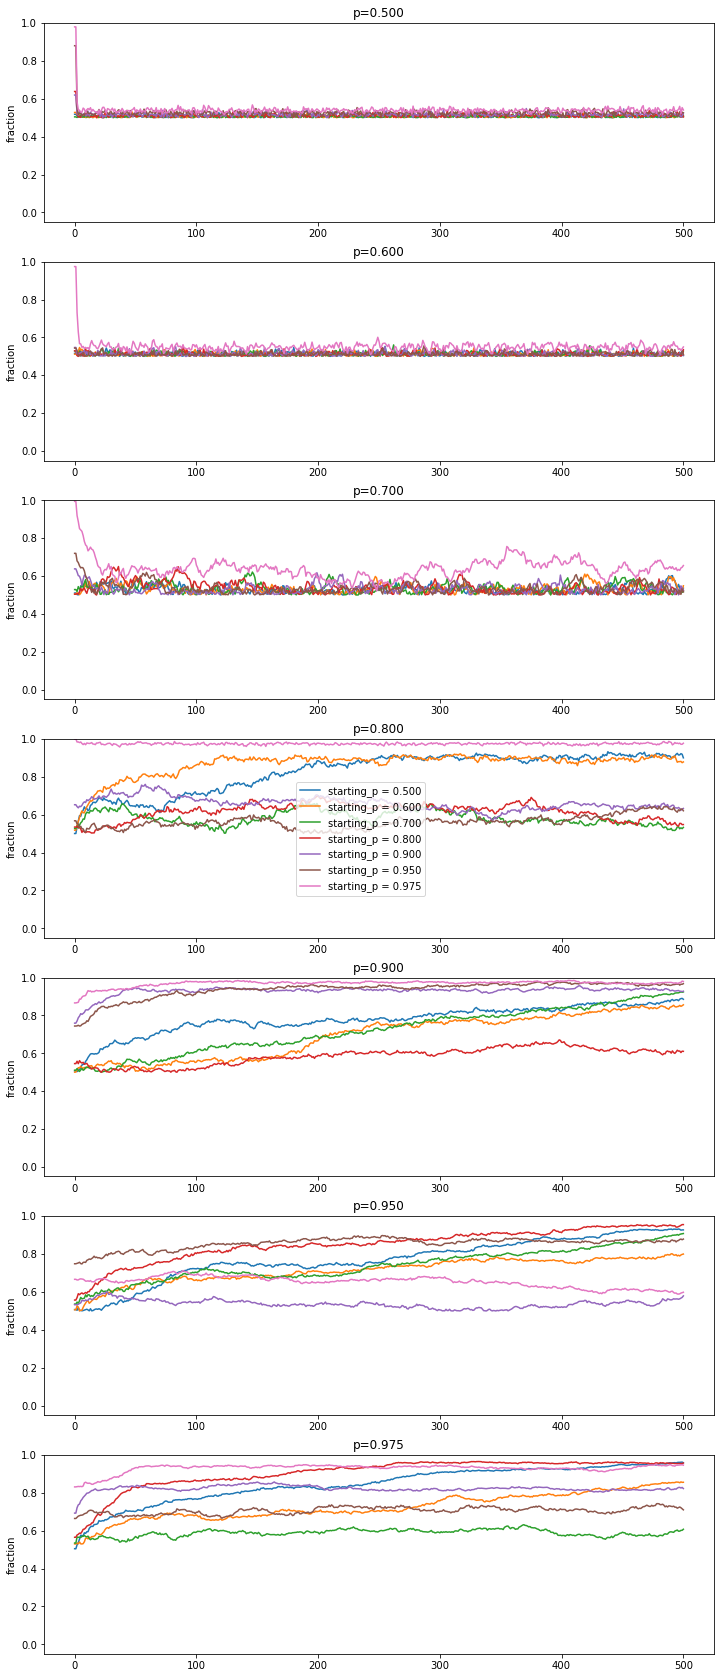

In [6]:
ps = sorted(list(set([x[2] for x in mts])))
fig, axs = plt.subplots(len(ps), 1, figsize=(12, 30))
for i, p in enumerate(ps):
    trajectories = [(x[1], x[3]) for x in mts if x[2] == p]
    ax = axs[i]
    legends = []
    for starting_p, trajectory in trajectories:
        ax.plot(trajectory)
        legends.append(f'starting_p = {starting_p:.3f}')
    ax.set_title(f'p={p:.3f}')
    ax.set_ylabel('fraction')
    ax.set_ylim((-0.05, 1.0))
plt.figlegend(legends, loc = 'center')

Text(0, 0.5, 'fraction')

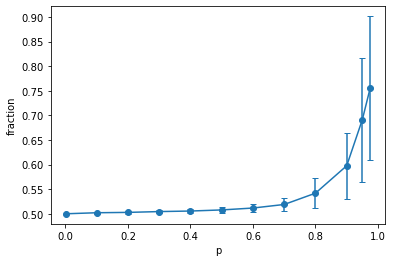

In [7]:
rows, cols, p0 = 50, 50, 0.5
num_samples = 100
pairs = []
for p in [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975]:
    rs = []
    for _ in range(num_samples):
        grid = create_grid(rows, cols, p0, p)
        rs.append(fraction(grid))
    pairs.append((p, np.mean(rs), np.std(rs)))
plt.errorbar([x[0] for x in pairs], [x[1] for x in pairs], [x[2] for x in pairs],
             marker='o', capsize=3)
plt.xlabel('p')
plt.ylabel('fraction')